In [6]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dls import build_dataloaders
from src.metrics.map import calculate_image_precision
from src.model.FasterRCNN import get_faster_rcnn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Get DataLoaders

In [7]:
data_path = '/userhome/34/h3509807/wheat-data'

In [8]:
dls = build_dataloaders(data_path, resize_sz = 256, rand_seed = 144)

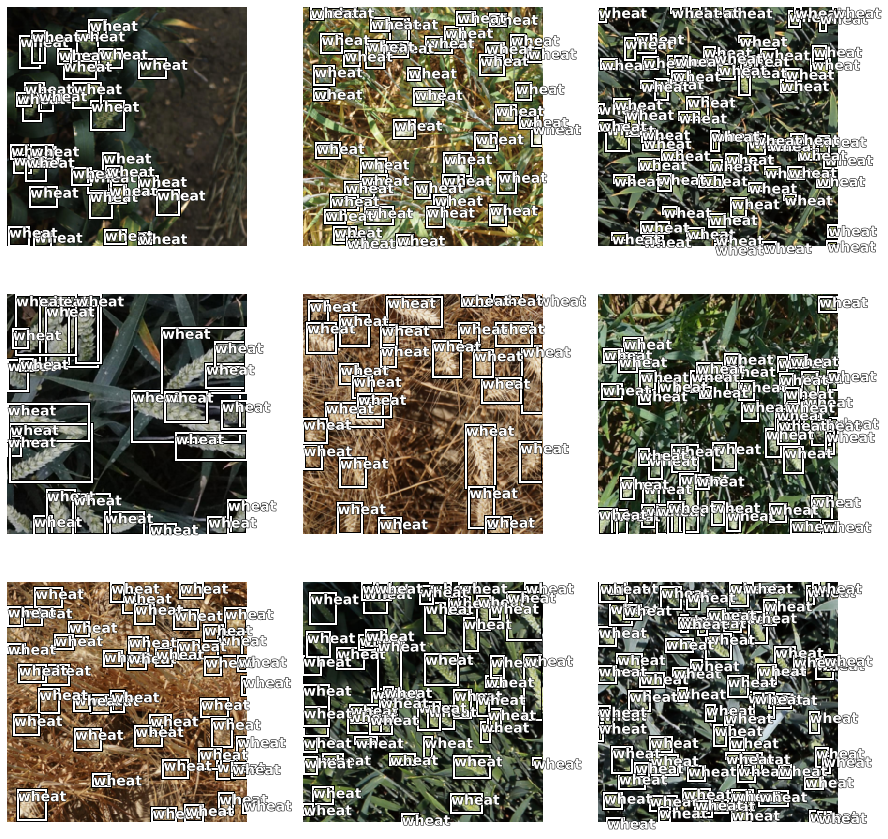

In [4]:
dls.show_batch(figsize = (15, 15))

In [21]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [17]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 108, 4]),
 torch.Size([64, 108]))

#### 2. Setup Model

In [13]:
model = get_faster_rcnn()

#### 3. Setup Dummy Loss Function

In [23]:
import torch
import torch.nn as nn

In [36]:
class WeightedMultiLoss(nn.Module):
    def forward(self, preds, tgts, **kwargs):
        loss = 0.
        for _, ind_loss in preds.items():
            loss += ind_loss
        return loss

In [37]:
multi_loss = WeightedMultiLoss()

#### 4. Freezing Selected Layers

#### 5. Setup Metrics

In [38]:
from functools import partial

In [49]:
thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

In [50]:
map_getter = partial(calculate_image_precision, thresholds = thresholds)

#### 6. Setup Callback

#### 7. Setup Learner

In [ ]:
learn = Learner(dls, arch, 
               loss_func = multi_loss, 
               #splitter = _retinanet_split,
               metrics = map_getter)